In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import wget
import cmocean as cmocean

In [2]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data/data/raw/Background Data/'

wind_dir= data_dir + 'winds_2019.nc'
ds_wind = xr.load_dataset(wind_dir)
flux_dir= data_dir+'surf_flux_2019.nc'
ds_flux = xr.load_dataset(flux_dir)

In [5]:
print(ds.time[0].values)
print(ds.time[-1].values)

2019-01-01T00:00:00.000000000
2019-12-31T23:00:00.000000000


In [6]:
glider_dates_start = "2019-04-30T13:20:51.230003456"
glider_dates_end   = "2019-07-26T01:58:44.700995328"

In [150]:
# uncomment below if the weekly averages were not saved.
#ds_wind_mean = ds_wind.rolling(time=24*7, center=True).mean()
#ds_wind_mean.to_netcdf('/Users/dhruvbalwada/OneDrive/sogos_data/data/interim/wind_mean.nc')
ds_wind_mean = xr.open_dataset('/Users/dhruvbalwada/OneDrive/sogos_data/data/interim/wind_mean.nc')

In [7]:
#ds_flux_mean = ds_flux.rolling(time=24*7, center=True).mean()
#ds_flux_mean.to_netcdf('/Users/dhruvbalwada/OneDrive/sogos_data/data/interim/flux_mean.nc')
ds_flux_mean = xr.open_dataset('/Users/dhruvbalwada/OneDrive/sogos_data/data/interim/flux_mean.nc')

## Heat Fluxes

We need to divide by 1hours (3600s - rate at which data was downloaded) since the data provides accumulations, rather than rates. 

In [8]:
# We add all the fluxes together since in ECMWF positive is always downwards
# So positive short wave will heat the ocean 
# Positive latent would mean that condensation took place.
surf_heat_flux_mean = (ds_flux_mean.slhf + ds_flux_mean.ssr + 
                  ds_flux_mean.str + ds_flux_mean.sshf)/3600

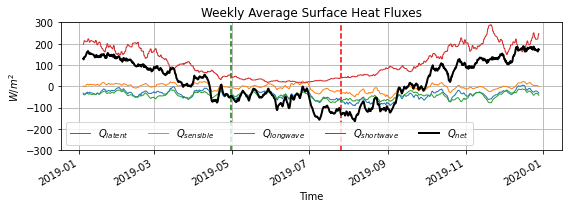

In [38]:
plt.figure(figsize=(8,3))
(ds_flux_mean.slhf/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='$Q_{latent}$', linewidth=1)
(ds_flux_mean.sshf/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='$Q_{sensible}$', linewidth=1)
(ds_flux_mean.str/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='$Q_{longwave}$', linewidth=1)
(ds_flux_mean.ssr/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='$Q_{shortwave}$', linewidth=1)
surf_heat_flux_mean.sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(color='k',label='$Q_{net}$', linewidth=2)

plt.vlines(glider_dates_start, -300, 300, color='green', linestyles='dashed')
plt.vlines(glider_dates_end, -300, 300, color='red', linestyles='dashed')
plt.ylim([-300, 300])
plt.legend(loc=0, ncol=5)
plt.grid()
plt.ylabel('$W/m^2$')
plt.xlabel('Time')
plt.title('Weekly Average Surface Heat Fluxes')

plt.tight_layout()
plt.savefig('Hflux.pdf')

## FW Fluxes


In [36]:
surf_fw_flux_mean = (ds_flux_mean.tp + ds_flux_mean.e)/3600

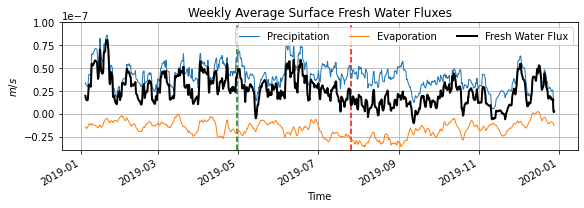

In [45]:
plt.figure(figsize=(8,3))
(ds_flux_mean.tp/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='Precipitation', linewidth=1)
(ds_flux_mean.e/3600).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(label='Evaporation', linewidth=1)
surf_fw_flux_mean.sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
                       ).mean(['latitude','longitude']).plot(color='k',label='Fresh Water Flux', linewidth=2)

plt.vlines(glider_dates_start, -4e-8, 1e-7, color='green', linestyles='dashed')
plt.vlines(glider_dates_end, -4e-8, 1e-7, color='red', linestyles='dashed')
plt.ylim([-4e-8, 1e-7])
plt.legend(loc=0, ncol=5)
plt.grid()
plt.ylabel('$m/s$')
plt.xlabel('Time')
plt.title('Weekly Average Surface Fresh Water Fluxes')

plt.tight_layout()
plt.savefig('FWflux.pdf')

## Wind Stress

In [67]:
def windstress(u10, v10):
    # adopted from https://github.com/chadagreene/CDT/blob/master/cdt/windstress.m
    U = (u10**2 + v10**2)**0.5
    Cd = 1.25e-3; # Drag coefficient, a global average from Kara et al., 2007 (http://dx.doi.org/10.1175/2007JCLI1825.1)
    rho = 1.225;  # density of air in kg/m^3
    Tau = rho*Cd*(u10**2 + v10**2);
    
    Taux = Tau*u10/U
    Tauy = Tau*v10/U
    
    return Tau, Taux, Tauy

In [77]:
[Tau, Taux, Tauy] = windstress(ds_wind.u10, ds_wind.v10)
[Tau_mean, Taux_mean, Tauy_mean] = windstress(ds_wind_mean.u10, ds_wind_mean.v10)

In [128]:
dir_wind = np.arctan2(-Taux,- Tauy).sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
        ).mean(['latitude','longitude'])*180/np.pi

dir_wind[dir_wind<0] = dir_wind[dir_wind<0] + 360

speed_wind = Tau.sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
        ).mean(['latitude','longitude'])
#http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv

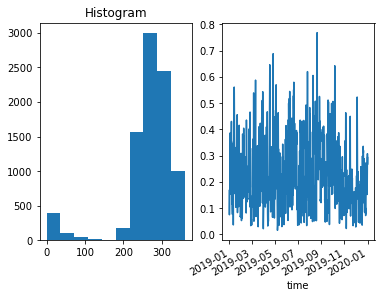

In [129]:
plt.subplot(121)
dir_wind.plot.hist()

plt.subplot(122)
speed_wind.plot()

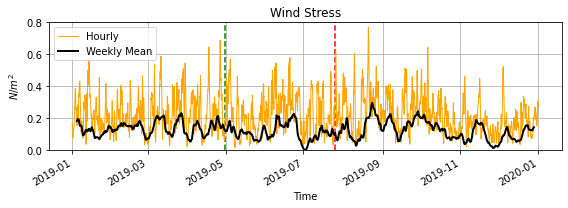

In [86]:
plt.figure(figsize=(8,3))
Tau.sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
        ).mean(['latitude','longitude']).plot(label='Hourly', linewidth=1,color='Orange')
Tau_mean.sel(latitude=slice(-50, -53.5), longitude=slice(30,39)
        ).mean(['latitude','longitude']).plot(label='Weekly Mean', linewidth=2, color='k')

plt.vlines(glider_dates_start, 0, .8, color='green', linestyles='dashed')
plt.vlines(glider_dates_end,  0, .8, color='red', linestyles='dashed')
plt.ylim([0, 0.8])
plt.legend(loc=2)
plt.grid()
plt.ylabel('$N/m^2$')
plt.xlabel('Time')
plt.title('Wind Stress')

plt.tight_layout()
plt.savefig('wind_stress.pdf')

In [116]:
from windrose import WindroseAxes   

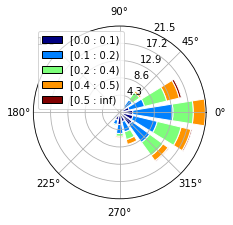

In [148]:
fig = plt.figure(figsize=(3,3))
ax = wr.WindroseAxes.from_ax(fig=fig)
ax.bar(dir_wind.sel(time=slice(glider_dates_start, glider_dates_end)), 
       speed_wind.sel(time=slice(glider_dates_start, glider_dates_end)), 
       bins=np.linspace(0,0.5,5), normed=True,
         edgecolor='white', blowto=True)
ax.legend(loc=0)

plt.savefig('windrose.pdf')